#### Тема «Анализ уровня преступности в Нью-Йорке в зависимости от погодных условий

Тема проекта выбрана не случайно. Я решил проверить насколько уровень социальной агрессии зависит от погодных условий, в особенности от температуры. Данная зависимость обсуждается в статьях по социалогии и статистике. Изначально использовался набор данных об арестах в Нью-Йорке за 2023 год, опубликованный департаментом полиции Нью-Йорка. Зависимость не была обнаружена. Я предплагал, что есть зависимость в этническом разрезе или гендерном или в разрезе классификации преступлений, и это не принесло результатов. На диаграмме ниже преставлена диаграмма рассеяния Количество арестов - Tемпература.

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'Количество арестов в день')

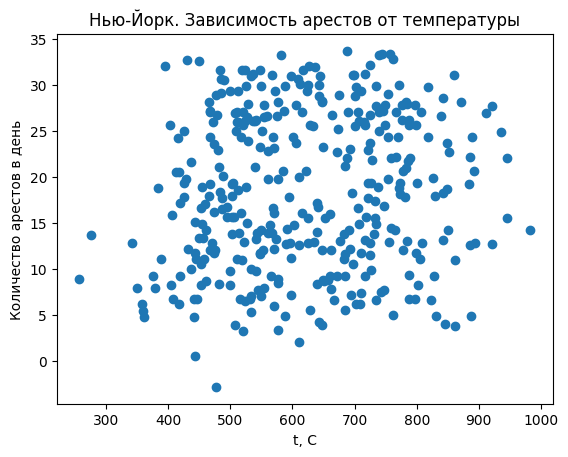

In [209]:
data = pd.read_csv("Arrest_Weather_Dataset.csv", sep=";")
plt.plot(data['Count-ARRESTS'], data['tempmax'], 'o')
plt.title("Нью-Йорк. Зависимость арестов от температуры")
plt.xlabel("t, C")
plt.ylabel("Количество арестов в день")

Хорошо видно, что никакой зависимости нет. Никакие разрезы даныых (по гендерным, этническим и тяжести преступления) не коррелируют с температурой. Об этом я говорил на предзащите. Негативный результат - тоже результат. Я смирился.
Однако, за день до защиты я решил проверить гипотезу на данных другого города. Я выбрал Чикаго. Данные нашёл быстро: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present-Map/ahwe-kpsy. Построил диаграмму рассеяния:
    

Text(0, 0.5, 'Количество инцидентов в день')

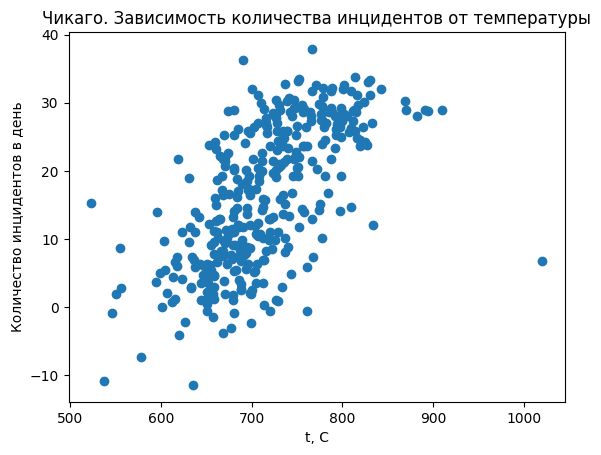

In [210]:
data = pd.read_csv("Chicago_Crimes_Weather_Dataset.csv", sep=";")
plt.plot(data['Count-ARRESTS'], data['tempmax'], 'o')
plt.title("Чикаго. Зависимость количества инцидентов от температуры")
plt.xlabel("t, C")
plt.ylabel("Количество инцидентов в день")

Корреляция есть! Слабенькая, но есть. Значит, и для Нью-Йорка это тоже должно соблюдаться - американцы везде одинаковы.

И тут снизошло озарение. Я осознал свою ошибку: были взяты данные об арестах. Количество арестов определяется не уровнем социальной агрессии, а количеством сотрудников полиции (ограничение мощности организации: n-е количество сотрудников может произвести количество арестов только из ограниченного диапазона).

Я начал искать данные именно об crime incidents. Я их нашёл: https://catalog.data.gov/dataset/nypd-complaint-data-historic
Строю диаграмму рассеяния.

Text(0, 0.5, 'Количество инцидентов в день')

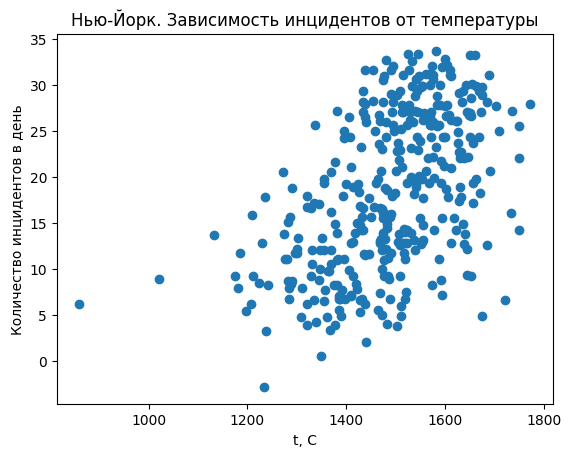

In [211]:
data = pd.read_csv("Complaint_Weather_Dataset.csv", sep=";")
plt.plot(data['Count-ARRESTS'], data['tempmax'], 'o')
plt.title("Нью-Йорк. Зависимость инцидентов от температуры")
plt.xlabel("t, C")
plt.ylabel("Количество инцидентов в день")

Да, корреляция есть. Очень интересно посмотреть корреляции для Чикаго и Нью-Йорка на одном графике:

In [212]:
data_nyc = pd.read_csv("Complaint_Weather_Dataset.csv", sep=";")
data_chi = pd.read_csv("Chicago_Crimes_Weather_Dataset.csv", sep=";")

Text(0, 0.5, 'Количество инцидентов в день')

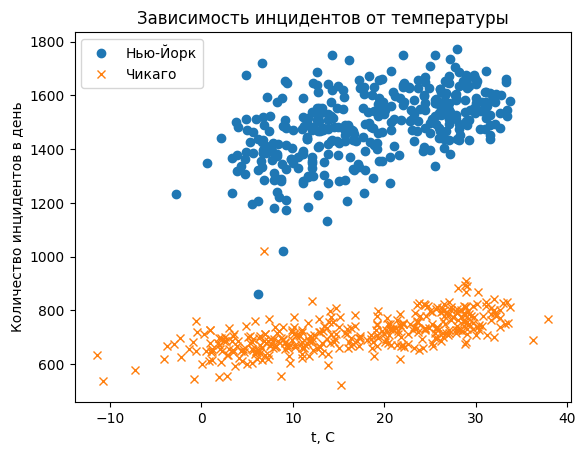

In [213]:
plt.plot(data_nyc['tempmax'], data_nyc['Count-ARRESTS'], 'o')
plt.plot(data_chi['tempmax'], data_chi['Count-ARRESTS'], 'x')
plt.title("Зависимость инцидентов от температуры")
plt.legend(['Нью-Йорк', 'Чикаго'])
plt.xlabel("t, C")
plt.ylabel("Количество инцидентов в день")

Замечательно. Особенно хорошо выглядит зависимость по Чикаго. Но, надо понимать, что это в определённой мере иллюзия.

### Построение модели

Предполагается построение двух моделей: гребневой регрессии и градиентного бустинга. Градиентный бустинг выбран по соображениям популярности в индустрии, а гребневая регрессия - как вариант для сравнения.

#### Загрузка данных

In [214]:
data = pd.read_csv("Complaint_Weather_Dataset.csv", sep=";")
data

,Count-ARRESTS,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
0,1645,12.2,10.0,11.1,12.2,8.5,11.0,4.3,64.9,0.365,...,20.0,281.2,1012.2,33.8,15.4,96.4,8.4,4,10,0.32
1,1303,13.4,8.4,11.3,13.4,7.1,11.0,4.2,62.3,0.440,...,12.1,265.0,1019.3,55.7,15.5,43.8,3.6,3,10,0.35
2,1470,13.0,7.9,10.6,13.0,6.6,10.3,8.7,87.9,9.585,...,12.5,98.7,1014.4,90.4,8.7,16.2,1.5,1,10,0.39
3,1603,18.7,9.2,14.4,18.7,7.4,14.2,10.8,79.7,0.459,...,15.2,190.5,1009.9,67.6,13.3,59.1,5.1,3,10,0.42
4,1645,9.4,7.1,8.5,8.8,4.3,7.0,7.1,90.7,0.460,...,15.2,55.3,1013.4,100.0,9.6,26.9,2.3,1,10,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,1174,9.3,6.7,7.8,7.2,4.8,6.0,6.3,89.8,0.298,...,25.3,46.2,1018.2,97.6,12.5,28.5,2.5,2,10,0.52
361,1186,11.7,8.9,10.1,11.7,5.3,9.0,8.6,90.5,2.085,...,37.9,39.5,1005.7,100.0,10.9,15.4,1.3,1,10,0.55
362,1301,12.2,7.9,9.5,12.2,6.8,8.9,6.3,81.8,0.040,...,21.3,260.4,1005.0,84.5,12.7,87.7,7.4,5,10,0.59
363,1285,7.9,3.9,6.0,6.6,0.3,3.3,0.2,66.5,0.000,...,32.4,270.2,1005.0,66.9,16.0,43.4,3.8,3,10,0.62


##### EDA

In [215]:
data.describe()

,Count-ARRESTS,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.00000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,1488.578082,18.457260,11.398904,14.598630,18.406575,9.940822,13.891233,7.080548,63.25863,1.149890,...,19.899178,190.109041,1015.985479,42.280548,15.085205,141.975616,12.261096,5.739726,13.698630,0.484110
std,128.254116,8.451405,7.770439,7.882867,9.384595,9.336535,9.003371,8.795705,14.38442,4.905872,...,6.017851,105.546694,7.578931,33.043860,1.837282,92.215786,7.973450,3.065348,11.224097,0.285358
min,860.000000,-2.800000,-14.200000,-8.300000,-8.200000,-23.400000,-13.700000,-18.200000,27.00000,0.000000,...,9.300000,0.700000,992.300000,0.100000,4.100000,0.000000,0.000000,0.000000,10.000000,0.000000
25%,1410.000000,11.700000,4.400000,7.800000,11.700000,1.300000,6.300000,0.000000,53.20000,0.000000,...,15.000000,70.800000,1010.900000,12.200000,15.200000,64.700000,5.700000,3.000000,10.000000,0.250000
50%,1499.000000,18.200000,11.100000,14.400000,18.200000,11.100000,14.200000,7.100000,62.90000,0.000000,...,18.600000,238.300000,1016.100000,36.700000,15.900000,133.000000,11.500000,6.000000,10.000000,0.500000
75%,1577.000000,26.100000,18.300000,21.800000,26.100000,18.300000,21.800000,14.100000,73.80000,0.460000,...,23.600000,270.700000,1021.100000,71.800000,16.000000,220.600000,19.100000,8.000000,10.000000,0.730000
max,1773.000000,33.700000,25.100000,29.000000,37.900000,25.100000,30.600000,24.000000,95.40000,60.941000,...,45.600000,359.800000,1036.700000,100.000000,16.000000,326.600000,28.000000,10.000000,75.000000,0.980000


In [216]:
data.shape

(365, 26)

In [217]:
data.empty

False

In [218]:
data[data.isna().any(axis=1)]

,Count-ARRESTS,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase


In [219]:
data['preciptypeex'].value_counts(normalize=True)

preciptypeex
none         0.517808
rain         0.452055
rain,snow    0.027397
snow         0.002740
Name: proportion, dtype: float64

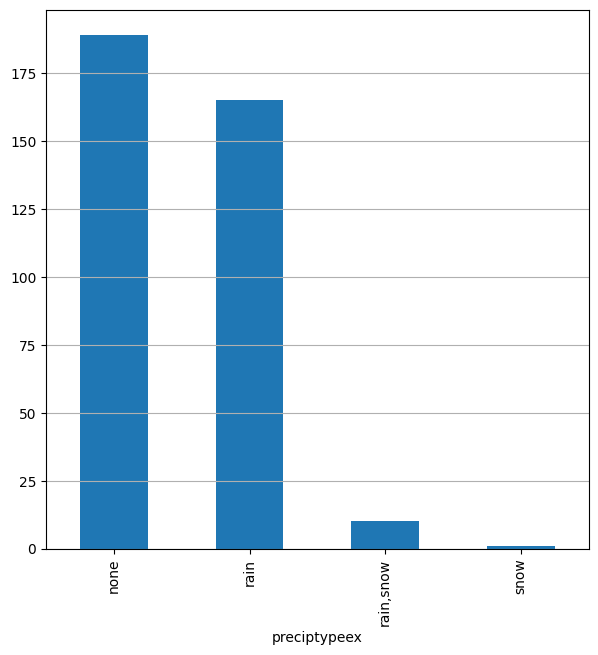

In [220]:
data['preciptypeex'].value_counts().plot.bar(figsize=(7, 7))
plt.grid(axis='y')

In [221]:
y = data.loc[:,'Count-ARRESTS']
y

0      1645
1      1303
2      1470
3      1603
4      1645
       ... 
360    1174
361    1186
362    1301
363    1285
364     860
Name: Count-ARRESTS, Length: 365, dtype: int64

In [222]:
X = data.drop('Count-ARRESTS', axis=1)
X

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
0,12.2,10.0,11.1,12.2,8.5,11.0,4.3,64.9,0.365,100,...,20.0,281.2,1012.2,33.8,15.4,96.4,8.4,4,10,0.32
1,13.4,8.4,11.3,13.4,7.1,11.0,4.2,62.3,0.440,100,...,12.1,265.0,1019.3,55.7,15.5,43.8,3.6,3,10,0.35
2,13.0,7.9,10.6,13.0,6.6,10.3,8.7,87.9,9.585,100,...,12.5,98.7,1014.4,90.4,8.7,16.2,1.5,1,10,0.39
3,18.7,9.2,14.4,18.7,7.4,14.2,10.8,79.7,0.459,100,...,15.2,190.5,1009.9,67.6,13.3,59.1,5.1,3,10,0.42
4,9.4,7.1,8.5,8.8,4.3,7.0,7.1,90.7,0.460,100,...,15.2,55.3,1013.4,100.0,9.6,26.9,2.3,1,10,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,9.3,6.7,7.8,7.2,4.8,6.0,6.3,89.8,0.298,100,...,25.3,46.2,1018.2,97.6,12.5,28.5,2.5,2,10,0.52
361,11.7,8.9,10.1,11.7,5.3,9.0,8.6,90.5,2.085,100,...,37.9,39.5,1005.7,100.0,10.9,15.4,1.3,1,10,0.55
362,12.2,7.9,9.5,12.2,6.8,8.9,6.3,81.8,0.040,100,...,21.3,260.4,1005.0,84.5,12.7,87.7,7.4,5,10,0.59
363,7.9,3.9,6.0,6.6,0.3,3.3,0.2,66.5,0.000,0,...,32.4,270.2,1005.0,66.9,16.0,43.4,3.8,3,10,0.62


##### Преобразование категориальных признаков

Преобразование категориальных признаков - признаков описания осадков.

In [223]:
from sklearn.preprocessing import OneHotEncoder

In [224]:
def EncodeCategoryOneHot(data, feature):
    encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
    data_encoded = encoder.fit_transform(data[[feature]])
    data_encoded = data.join(data_encoded)
    data_encoded = data_encoded.drop(feature, axis=1)
    return data_encoded

In [225]:
X = EncodeCategoryOneHot(X, "preciptypeex")
X

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,preciptypeex_none,preciptypeex_rain,"preciptypeex_rain,snow",preciptypeex_snow
0,12.2,10.0,11.1,12.2,8.5,11.0,4.3,64.9,0.365,100,...,15.4,96.4,8.4,4,10,0.32,0.0,1.0,0.0,0.0
1,13.4,8.4,11.3,13.4,7.1,11.0,4.2,62.3,0.440,100,...,15.5,43.8,3.6,3,10,0.35,0.0,1.0,0.0,0.0
2,13.0,7.9,10.6,13.0,6.6,10.3,8.7,87.9,9.585,100,...,8.7,16.2,1.5,1,10,0.39,0.0,1.0,0.0,0.0
3,18.7,9.2,14.4,18.7,7.4,14.2,10.8,79.7,0.459,100,...,13.3,59.1,5.1,3,10,0.42,0.0,1.0,0.0,0.0
4,9.4,7.1,8.5,8.8,4.3,7.0,7.1,90.7,0.460,100,...,9.6,26.9,2.3,1,10,0.46,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,9.3,6.7,7.8,7.2,4.8,6.0,6.3,89.8,0.298,100,...,12.5,28.5,2.5,2,10,0.52,0.0,1.0,0.0,0.0
361,11.7,8.9,10.1,11.7,5.3,9.0,8.6,90.5,2.085,100,...,10.9,15.4,1.3,1,10,0.55,0.0,1.0,0.0,0.0
362,12.2,7.9,9.5,12.2,6.8,8.9,6.3,81.8,0.040,100,...,12.7,87.7,7.4,5,10,0.59,0.0,1.0,0.0,0.0
363,7.9,3.9,6.0,6.6,0.3,3.3,0.2,66.5,0.000,0,...,16.0,43.4,3.8,3,10,0.62,1.0,0.0,0.0,0.0


In [226]:
X[X.isna().any(axis=1)]

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,preciptypeex_none,preciptypeex_rain,"preciptypeex_rain,snow",preciptypeex_snow


In [227]:
features_names = X.columns.tolist()
print(features_names)

['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase', 'preciptypeex_none', 'preciptypeex_rain', 'preciptypeex_rain,snow', 'preciptypeex_snow']


##### Шкалирование признаков


Шкалирование необходимо для построения модели линейной (гребневой) регрессии.

In [228]:
from sklearn.preprocessing import StandardScaler

In [229]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X.to_numpy())
Xs = pd.DataFrame(Xs, columns = features_names)
Xs.describe()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,preciptypeex_none,preciptypeex_rain,"preciptypeex_rain,snow",preciptypeex_snow
count,3.650000e+02,3.650000e+02,365.000000,365.000000,3.650000e+02,3.650000e+02,365.000000,3.650000e+02,3.650000e+02,3.650000e+02,...,3.650000e+02,3.650000e+02,3.650000e+02,3.650000e+02,3.650000e+02,3.650000e+02,3.650000e+02,3.650000e+02,365.000000,3.650000e+02
mean,3.114708e-16,1.946692e-16,0.000000,0.000000,3.893385e-17,-1.168015e-16,0.000000,2.725369e-16,-1.946692e-17,7.300097e-17,...,-1.557354e-16,3.893385e-16,2.920039e-16,-1.362685e-16,3.893385e-17,1.295767e-16,3.406712e-17,-2.190029e-17,0.000000,-1.460019e-17
std,1.001373e+00,1.001373e+00,1.001373,1.001373,1.001373e+00,1.001373e+00,1.001373,1.001373e+00,1.001373e+00,1.001373e+00,...,1.001373e+00,1.001373e+00,1.001373e+00,1.001373e+00,1.001373e+00,1.001373e+00,1.001373e+00,1.001373e+00,1.001373,1.001373e+00
min,-2.518687e+00,-3.298918e+00,-2.908848,-2.839025,-3.575908e+00,-3.068751e+00,-2.878138,-2.524148e+00,-2.347124e-01,-9.388521e-01,...,-5.987260e+00,-1.541715e+00,-1.539851e+00,-1.875025e+00,-3.299782e-01,-1.698828e+00,-1.036274e+00,-9.082951e-01,-0.167836,-5.241424e-02
25%,-8.006404e-01,-9.019453e-01,-0.863640,-0.715618,-9.267553e-01,-8.443119e-01,-0.806106,-7.002324e-01,-2.347124e-01,-9.388521e-01,...,6.256639e-02,-8.391371e-01,-8.239974e-01,-8.950002e-01,-3.299782e-01,-8.215326e-01,-1.036274e+00,-9.082951e-01,-0.167836,-5.241424e-02
50%,-3.048173e-02,-3.851963e-02,-0.025232,-0.022042,1.243255e-01,3.434169e-02,0.002215,-2.496607e-02,-2.347124e-01,-9.388521e-01,...,4.440870e-01,-9.746636e-02,-9.558481e-02,8.502502e-02,-3.299782e-01,5.576231e-02,9.649958e-01,-9.082951e-01,-0.167836,-5.241424e-02
75%,9.055572e-01,8.893408e-01,0.914801,0.820918,8.965481e-01,8.796287e-01,0.799150,7.338384e-01,-1.408185e-01,1.065130e+00,...,4.985899e-01,8.537834e-01,8.588869e-01,7.383751e-01,-3.299782e-01,8.628736e-01,9.649958e-01,1.100964e+00,-0.167836,-5.241424e-02
max,1.806050e+00,1.765654e+00,1.829428,2.080024,1.625869e+00,1.858382e+00,1.926244,2.237524e+00,1.220439e+01,1.065130e+00,...,4.985899e-01,2.004839e+00,1.976624e+00,1.391725e+00,5.469083e+00,1.740169e+00,9.649958e-01,1.100964e+00,5.958188,1.907878e+01


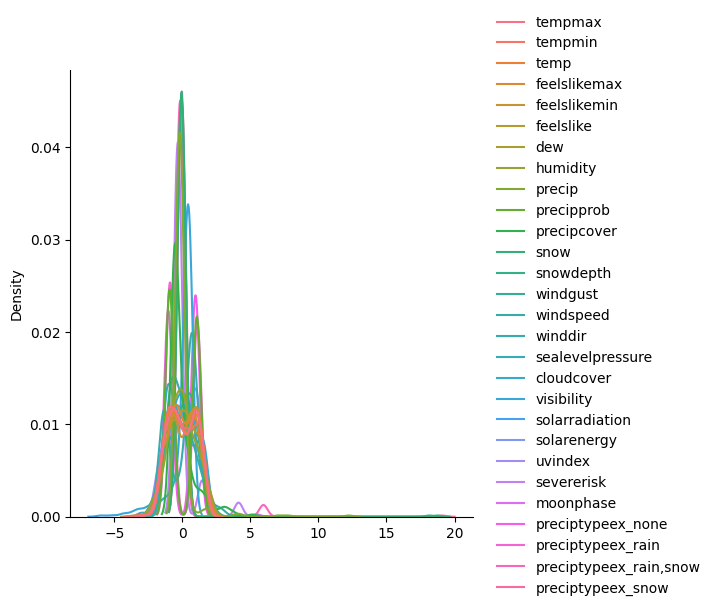

In [230]:
sns.displot(Xs, kind="kde")

array([[<Axes: title={'center': 'tempmax'}>,
        <Axes: title={'center': 'tempmin'}>,
        <Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'feelslikemax'}>,
        <Axes: title={'center': 'feelslikemin'}>],
       [<Axes: title={'center': 'feelslike'}>,
        <Axes: title={'center': 'dew'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'precip'}>,
        <Axes: title={'center': 'precipprob'}>],
       [<Axes: title={'center': 'precipcover'}>,
        <Axes: title={'center': 'snow'}>,
        <Axes: title={'center': 'snowdepth'}>,
        <Axes: title={'center': 'windgust'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'winddir'}>,
        <Axes: title={'center': 'sealevelpressure'}>,
        <Axes: title={'center': 'cloudcover'}>,
        <Axes: title={'center': 'visibility'}>,
        <Axes: title={'center': 'solarradiation'}>],
       [<Axes: title={'center': 'solarenergy'}>,
        <Ax

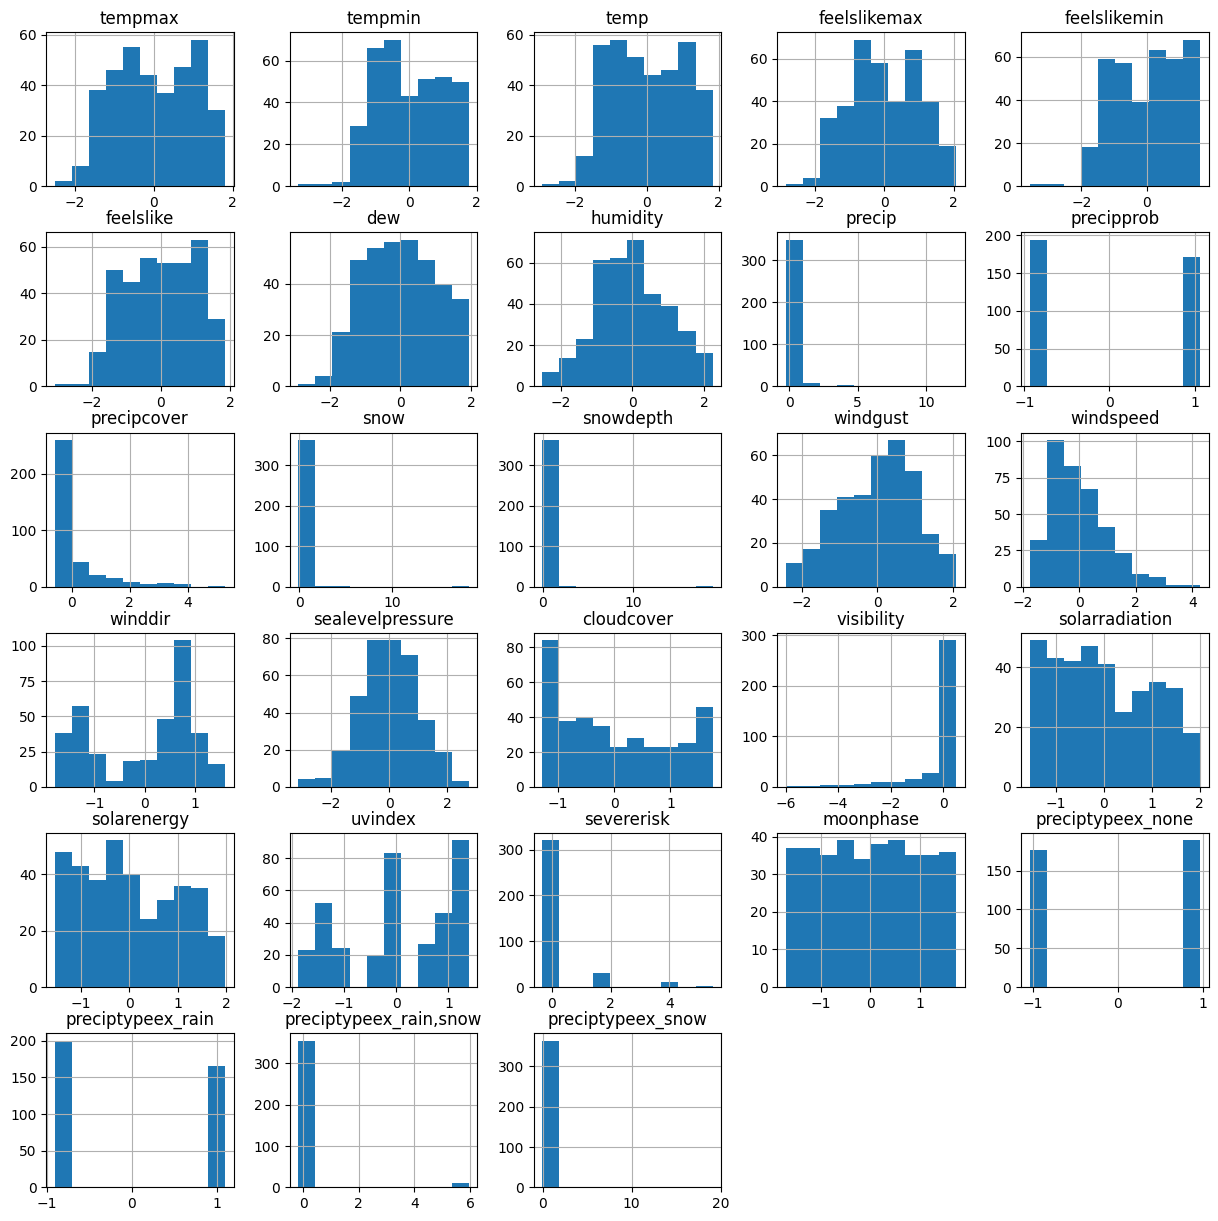

In [231]:
Xs.hist(figsize=(15, 15))

<Axes: >

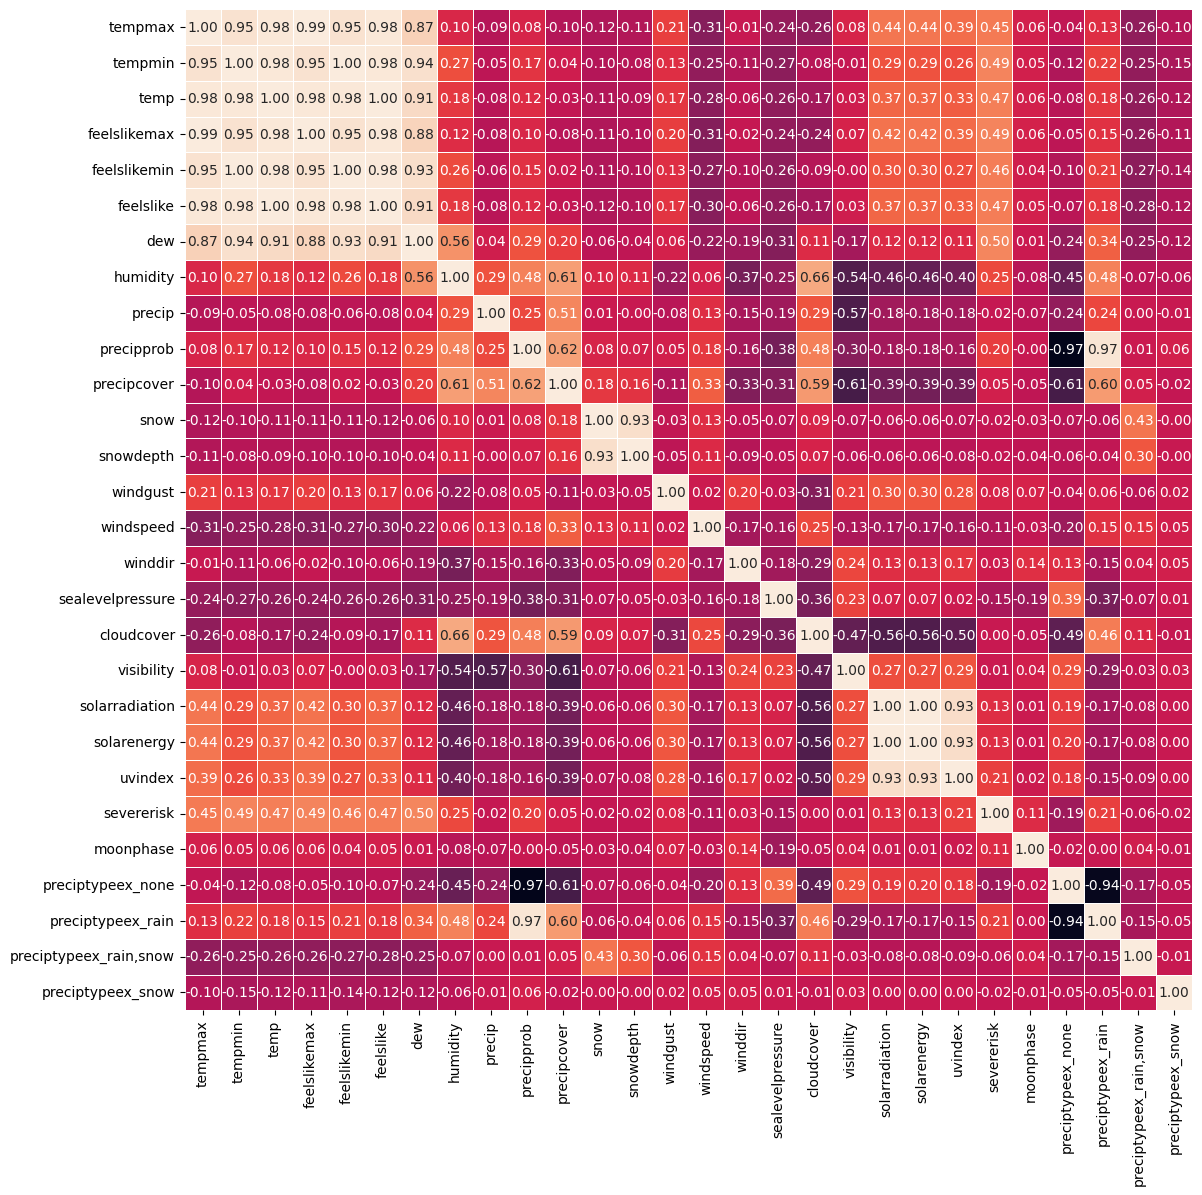

In [232]:
plt.figure(figsize=(13, 13))
sns.heatmap(Xs.corr(), annot=True, cbar=False, linewidths=0.5, fmt='.2f')

На тепловой карте отчётливо видны три группы коррелирующих признаков: группа температурных признаков, группа признаков описания солнечной активности и группа описания осадков. Поэтому для обучающего набора из указанных груп выберем по одному признаку: tempmax, snow, solarradiation
Для построения paiplot, в целях информативности графиков, отобраны наиболее значимые параметры. При большом количестве признаков графики плохо читаются.

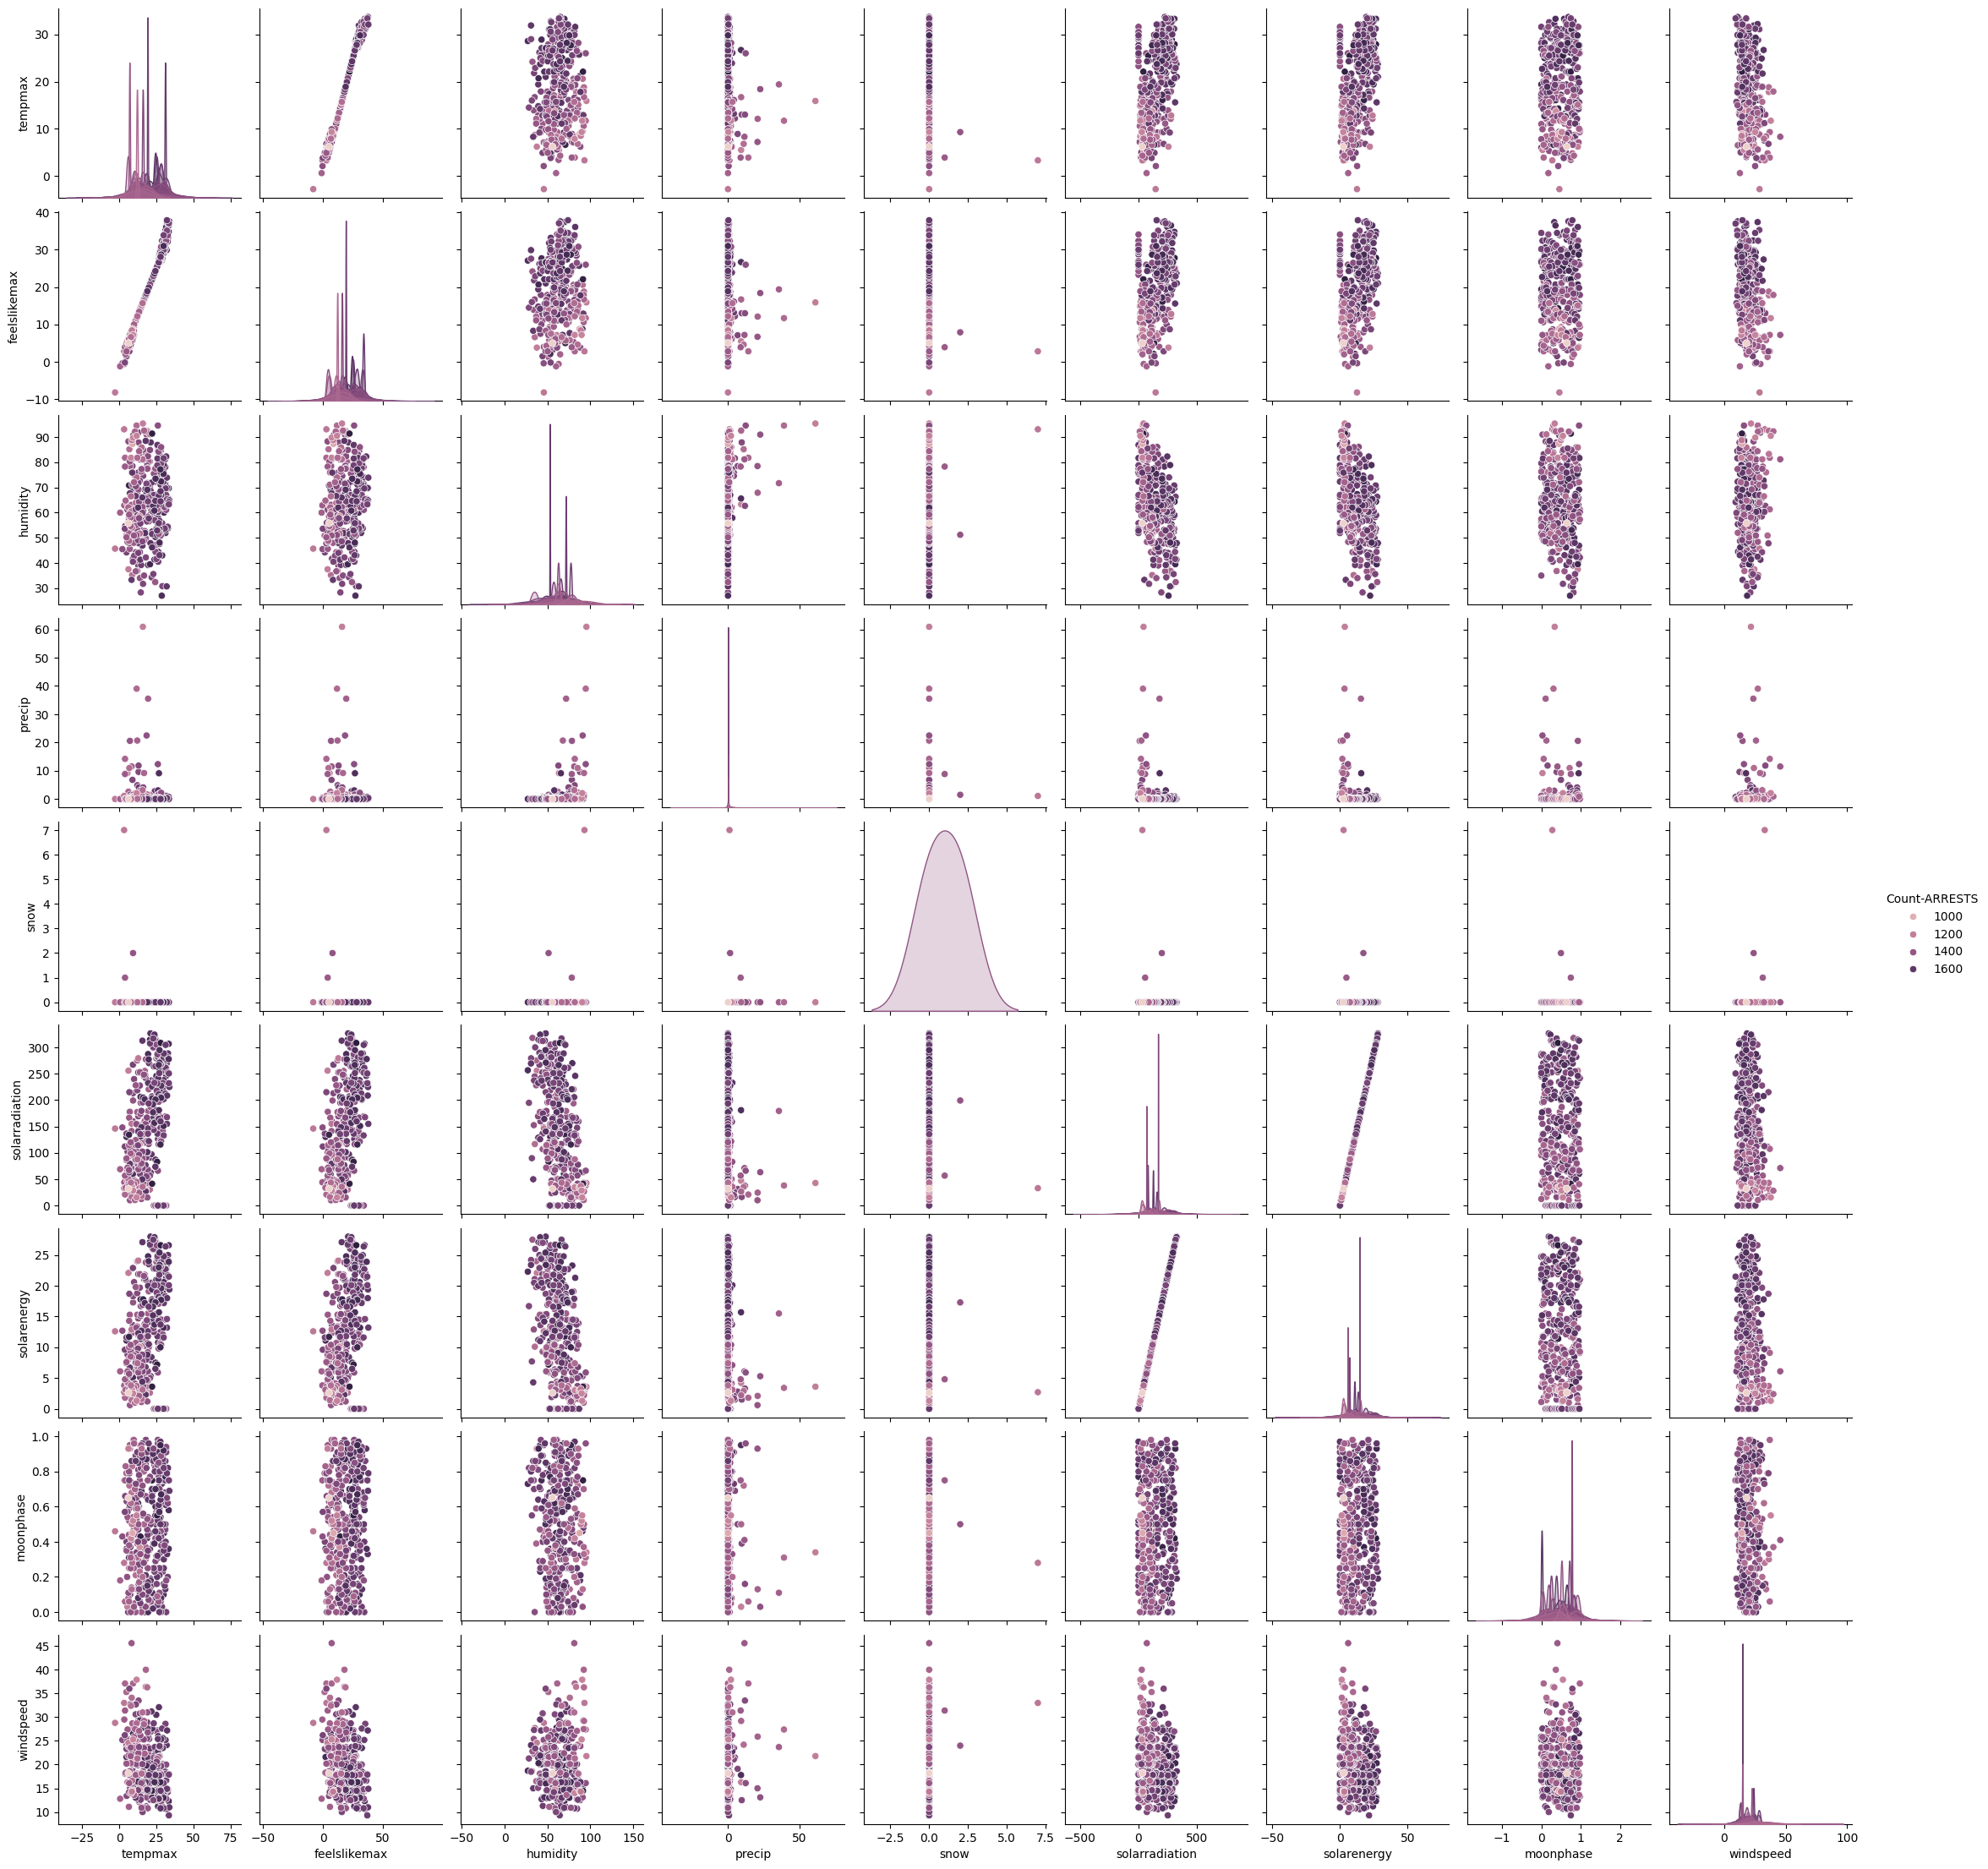

In [233]:
sns.pairplot(data, hue='Count-ARRESTS', vars=[
    'tempmax', 'feelslikemax', 'humidity', 'precip', 'snow', 'solarradiation', 'solarenergy', 'moonphase', 'windspeed'
    ], height=2.5
)

Отчётливо видно, что признак tempmax имеет существенный вклад в дисперсию целевого признака (строка 1), причём в сочетании с такими признаками, как solarradiation, moophase и windspeed (последние четыре ячейки первой строки). Признаки humidity, precip и snow, а также коррелируемые с ними признаки следует отбросить.

#### Построение модели

In [234]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

##### Разведывательная модель - гребневая регрессия с учётом всех признаков

In [235]:
alphas = [0.0001, 0.001, 0.01, 1.0, 5.0, 10, 100, 200, 300, 400, 500, 1000]
ridgecv = RidgeCV(cv=5, alphas=alphas, gcv_mode='svd')
ridgecv.fit(Xs, y)
print(ridgecv.alpha_)
print(ridgecv.best_score_)

200.0
0.1072111438840272


In [236]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.7, random_state=13)
ridge = Ridge().fit(X_train, y_train)
print(ridge.score(X_train, y_train))
print(ridge.score(X_test, y_test))

0.3715506291171693
-0.39801979567647594


Результат удручающий, отрицательный score - модель ничего не обобщает. Видимо сказывается влияние "плохих" признаков. Уберём лишние признаки.

In [237]:
import sys

np.set_printoptions(threshold=sys.maxsize)
features_coef = pd.Series(ridgecv.coef_, index = Xs.columns)
features_coef = features_coef[np.abs(features_coef) > 0.5 ]
features_coef

tempmax                    7.773620
tempmin                    7.188193
temp                       7.648007
feelslikemax               6.577495
feelslikemin               7.943183
feelslike                  7.948935
dew                        6.773837
humidity                  -0.935450
precip                    -6.668216
precipprob                 3.723672
precipcover              -16.364246
snow                      -3.840344
snowdepth                  1.040352
windgust                   6.457506
windspeed                 -5.481475
winddir                   -2.669739
sealevelpressure          -5.218240
cloudcover                -3.384137
visibility                 5.498347
solarradiation             5.300424
solarenergy                5.278788
uvindex                    3.587120
severerisk                -6.014047
moonphase                  4.285101
preciptypeex_none         -2.135068
preciptypeex_rain          1.435793
preciptypeex_rain,snow     1.502406
preciptypeex_snow          2

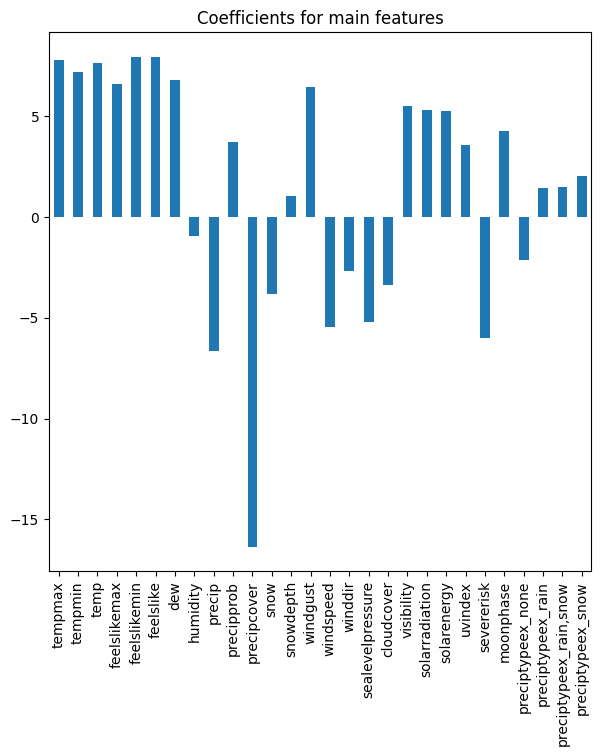

In [238]:
plot = features_coef.plot(title="Coefficients for main features", figsize=(7, 7), rot=90, kind="bar")

##### Разведывательная модель - гребневая регрессия с ограниченным набором признаков

In [239]:
Xsf = Xs.drop(['dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'uvindex', 'preciptypeex_none', 'preciptypeex_rain', 'preciptypeex_rain,snow', 'preciptypeex_snow'], axis=1)
Xsf

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,windgust,solarradiation,solarenergy,severerisk,moonphase
0,-0.741397,-0.180276,-0.444436,-0.662266,-0.154533,-0.321569,-1.142689,-0.494906,-0.484909,-0.329978,-0.575890
1,-0.599214,-0.386467,-0.419030,-0.534221,-0.304687,-0.321569,-2.136056,-1.066091,-1.087733,-0.329978,-0.470615
2,-0.646609,-0.450902,-0.507952,-0.576903,-0.358314,-0.399424,-1.833265,-1.365799,-1.351469,-0.329978,-0.330247
3,0.028761,-0.283372,-0.025232,0.031310,-0.272511,0.034342,-1.737647,-0.899948,-0.899350,-0.329978,-0.224972
4,-1.073158,-0.553998,-0.774718,-1.025059,-0.604996,-0.766457,-2.231674,-1.249608,-1.250998,-0.329978,-0.084605
...,...,...,...,...,...,...,...,...,...,...,...
360,-1.085007,-0.605545,-0.863640,-1.195785,-0.551369,-0.877678,-1.142689,-1.232234,-1.225880,-0.329978,0.125946
361,-0.800640,-0.322033,-0.571468,-0.715618,-0.497743,-0.544013,-0.515858,-1.374487,-1.376586,-0.329978,0.231221
362,-0.741397,-0.450902,-0.647687,-0.662266,-0.336863,-0.555135,-0.648661,-0.589380,-0.610497,-0.329978,0.371588
363,-1.250887,-0.966380,-1.092297,-1.259807,-1.034008,-1.177978,1.157461,-1.070434,-1.062615,-0.329978,0.476864


In [240]:
alphas = [0.0001, 0.001, 0.01, 1.0, 5.0, 10, 100, 200, 300, 400, 500, 1000]
ridgecv = RidgeCV(cv=5, alphas=alphas, gcv_mode='svd')
ridgecv.fit(Xsf, y)
print(ridgecv.alpha_)
print(ridgecv.best_score_)

200.0
0.0904805994688503


In [241]:
X_train, X_test, y_train, y_test = train_test_split(Xsf, y, test_size=0.7, random_state=13)
ridge = Ridge().fit(X_train, y_train)
print(ridge.score(X_train, y_train))
print(ridge.score(X_test, y_test))

0.24173304551329333
0.31342869905871573


Гораздо лучше, и соответствует интуитивным ожиданиям качества модели: 30 - 40. Стоит отметить, что модель недообучена: score на тестовых данных выше score на обучающих данных.

In [242]:
from sklearn.ensemble import GradientBoostingRegressor

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=13)
reg = GradientBoostingRegressor(random_state=13)
reg.fit(X_train, y_train)

GradientBoostingRegressor(random_state=13)

In [244]:
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))

0.9718384876574151
0.09486586122122576


Градиентный бустинг показал слабый результат, модель сильно переобучена. Оно и понятно: сказывается зашумлённость незначащими признаками.

#### Выводы

Зависимость между температурой и уровнем преступности есть, хоть и не сильная. Поскольку точность не очень высокая, то можно сказать, что найденая зависимость является производной от некоторой другой зависимости (процесса). Можно попытаться изучить модель в разрезах: психотип, этническое разделение, тип инцидента. А силовым структурам можно посоветовать выводить на улицы дополнительные патрули в жаркую погоду.